In [4]:
# ==============================
# CV LAB 4 COMPLETE IMPLEMENTATION
# ==============================


!pip install opencv-python scikit-image scikit-learn

import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MeanShift
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from tensorflow.keras.datasets import cifar10





In [3]:
# ==============================
# LOAD CIFAR-10 FROM OPENML (NO TORONTO SERVER)
# ==============================

from sklearn.datasets import fetch_openml

print("Downloading CIFAR-10 from OpenML...")

cifar = fetch_openml('CIFAR_10_small')

X = cifar.data
y = cifar.target.astype(int)

# Convert to numpy images
X = X.values.reshape(-1, 32, 32, 3).astype(np.uint8)

# Reduce dataset size for speed
x_train = X[:2000]
y_train = y[:2000]
x_test = X[2000:2500]
y_test = y[2000:2500]

print("Dataset loaded successfully.")


Dataset loaded successfully.


In [11]:
# ==============================
# 2. SIFT FEATURE EXTRACTION
# ==============================
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    descriptors_list = []

    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)

        if descriptors is None:
            descriptors = np.zeros((1, 128), dtype=np.float32)

        descriptors = descriptors.astype(np.float32)  # FORCE float32
        descriptors_list.append(descriptors)

    return descriptors_list



print("Extracting SIFT features...")
train_sift = extract_sift_features(x_train)
test_sift = extract_sift_features(x_test)



Extracting SIFT features...


In [12]:
# ==============================
# 3. BAG OF VISUAL WORDS (SIFT)
# ==============================

print("Building Visual Vocabulary...")

all_descriptors = np.vstack(train_sift).astype(np.float32)

kmeans = KMeans(n_clusters=100, random_state=42, n_init=10)
kmeans.fit(all_descriptors)


def build_histograms(descriptor_list, kmeans):
    histograms = []

    for descriptors in descriptor_list:
        descriptors = descriptors.astype(np.float32)

        histogram = np.zeros(kmeans.n_clusters)

        clusters = kmeans.predict(descriptors)

        for c in clusters:
            histogram[c] += 1

        histograms.append(histogram)

    return np.array(histograms)


X_train_sift = build_histograms(train_sift, kmeans)
X_test_sift = build_histograms(test_sift, kmeans)

# Normalize
scaler = StandardScaler()
X_train_sift = scaler.fit_transform(X_train_sift)
X_test_sift = scaler.transform(X_test_sift)



Building Visual Vocabulary...


In [13]:
# ==============================
# 4. KNN CLASSIFIER (SIFT)
# ==============================

knn_sift = KNeighborsClassifier(n_neighbors=5)
knn_sift.fit(X_train_sift, y_train)

y_pred_sift = knn_sift.predict(X_test_sift)
sift_accuracy = accuracy_score(y_test, y_pred_sift)

print("SIFT Accuracy:", sift_accuracy)

# ==============================
# 5. HOG FEATURE EXTRACTION
# ==============================

def extract_hog_features(images):
    hog_features = []

    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        features = hog(
            gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys'
        )

        hog_features.append(features)

    return np.array(hog_features)

print("Extracting HOG features...")
X_train_hog = extract_hog_features(x_train)
X_test_hog = extract_hog_features(x_test)

# Normalize
scaler_hog = StandardScaler()
X_train_hog = scaler_hog.fit_transform(X_train_hog)
X_test_hog = scaler_hog.transform(X_test_hog)



SIFT Accuracy: 0.14
Extracting HOG features...


HOG Accuracy: 0.236
Performing Mean Shift Segmentation...


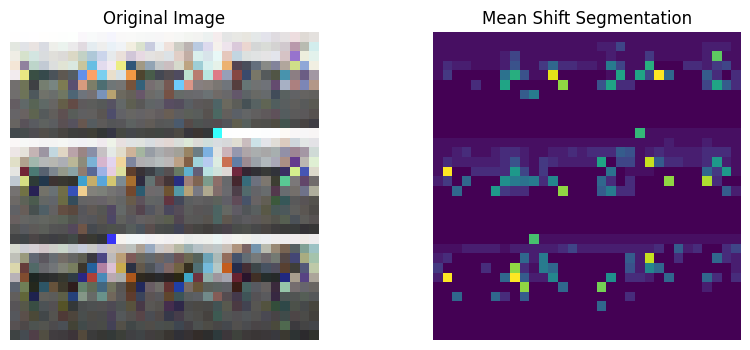

In [14]:
# ==============================
# 6. KNN CLASSIFIER (HOG)
# ==============================

knn_hog = KNeighborsClassifier(n_neighbors=5)
knn_hog.fit(X_train_hog, y_train)

y_pred_hog = knn_hog.predict(X_test_hog)
hog_accuracy = accuracy_score(y_test, y_pred_hog)

print("HOG Accuracy:", hog_accuracy)

# ==============================
# 7. MEAN SHIFT IMAGE SEGMENTATION
# ==============================

def mean_shift_segmentation(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    flat_image = img.reshape((-1, 3))

    ms = MeanShift(bandwidth=30, bin_seeding=True)
    ms.fit(flat_image)

    labels = ms.labels_
    segmented = labels.reshape(img.shape[:2])

    return segmented

print("Performing Mean Shift Segmentation...")
segmented_image = mean_shift_segmentation(x_test[0])

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(x_test[0])
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(segmented_image, cmap='viridis')
plt.title("Mean Shift Segmentation")
plt.axis("off")

plt.show()
